

IMPORT LIBRARIES/DATASETS AND PERFORM PRELIMINARY DATA PROCESSING


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/My Drive/Emotion detection")

In [3]:
# Import the necessary packages
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from keras import optimizers


In [4]:
# load the data
facialpoints_df = pd.read_csv('KeyFacialPoints.csv')

In [5]:
facialpoints_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,24.972418,36.348203,56.402841,31.171586,80.709708,30.595738,38.187845,30.595738,17.275454,29.534964,45.805390,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2136,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,15.979592,38.076531,56.941270,29.605102,81.314059,30.754762,35.059410,29.566780,8.578912,32.096032,53.649433,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,21.621652,39.095524,62.388142,32.089787,85.829396,38.724104,42.595762,30.541779,11.230184,34.485512,53.318891,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,16.850204,44.409861,51.463469,27.161327,77.354898,19.562755,34.135510,32.830102,9.731633,41.152347,54.075935,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [6]:
facialpoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [7]:
# Let's take a look at a sample image
len(facialpoints_df['Image'][1])

32691

In [8]:
# Since values for the image is given as space separated string, we will need to separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96,96)
facialpoints_df['Image'] = facialpoints_df['Image'].apply(lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(96,96))

In [9]:
# Let's obtain the shape of the resized image
facialpoints_df['Image'][1].shape

(96, 96)

In [10]:
# Let's confirm that there are no null values 
facialpoints_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [11]:
print(facialpoints_df["right_eye_center_x"].mean())
print(facialpoints_df["right_eye_center_x"].max())
print(facialpoints_df["right_eye_center_x"].min())


29.640268564561477
42.495171727
18.922610628599998


PERFORM IMAGE VISUALIZATION

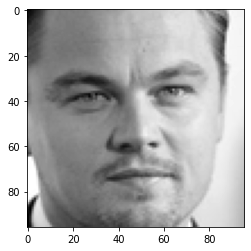

In [12]:
# Plot a random image from the dataset along with facial keypoints. 
i = np.random.randint(1, len(facialpoints_df))
plt.imshow(facialpoints_df['Image'][i],cmap='gray')


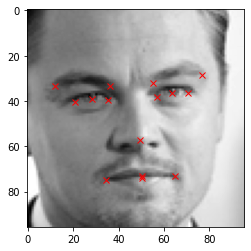

In [13]:
# The (x, y) coordinates for the 15 key features are plotted on top of the image
# Below is a for loop starting from index = 1 to 32 with step of 2
# In the first iteration j would be 1, followed by 3 and so on.
# since x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.
# in the first iteration df[i][j-1] would be df[i][0] refering the value in 1st column(x-coordinate) of the image in 'i' row.

plt.figure()
plt.imshow(facialpoints_df['Image'][i],cmap='gray')
for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')


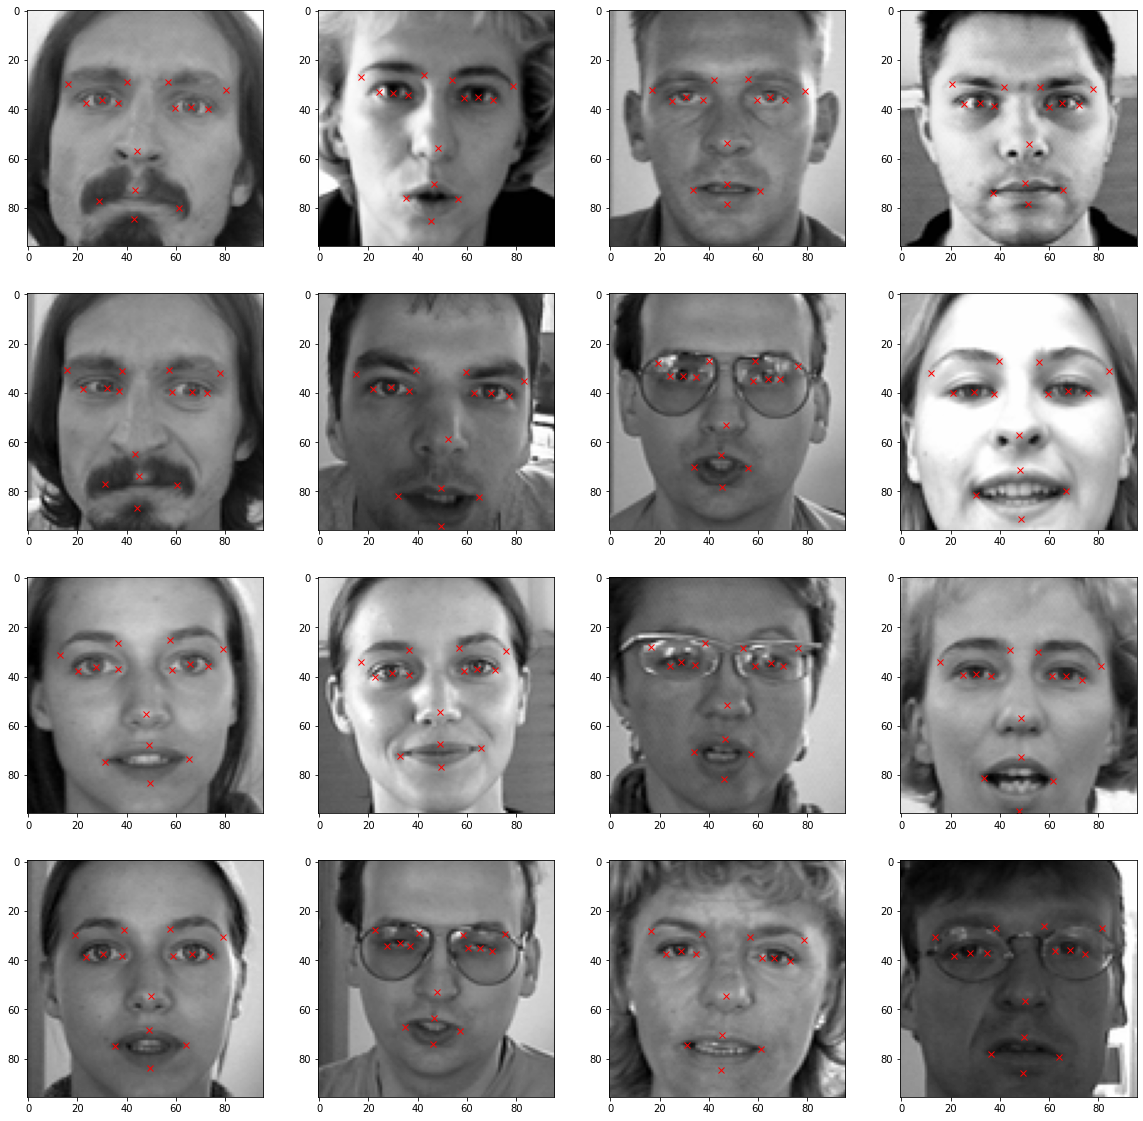

In [14]:
import random

# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(facialpoints_df['Image'][i], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')
    

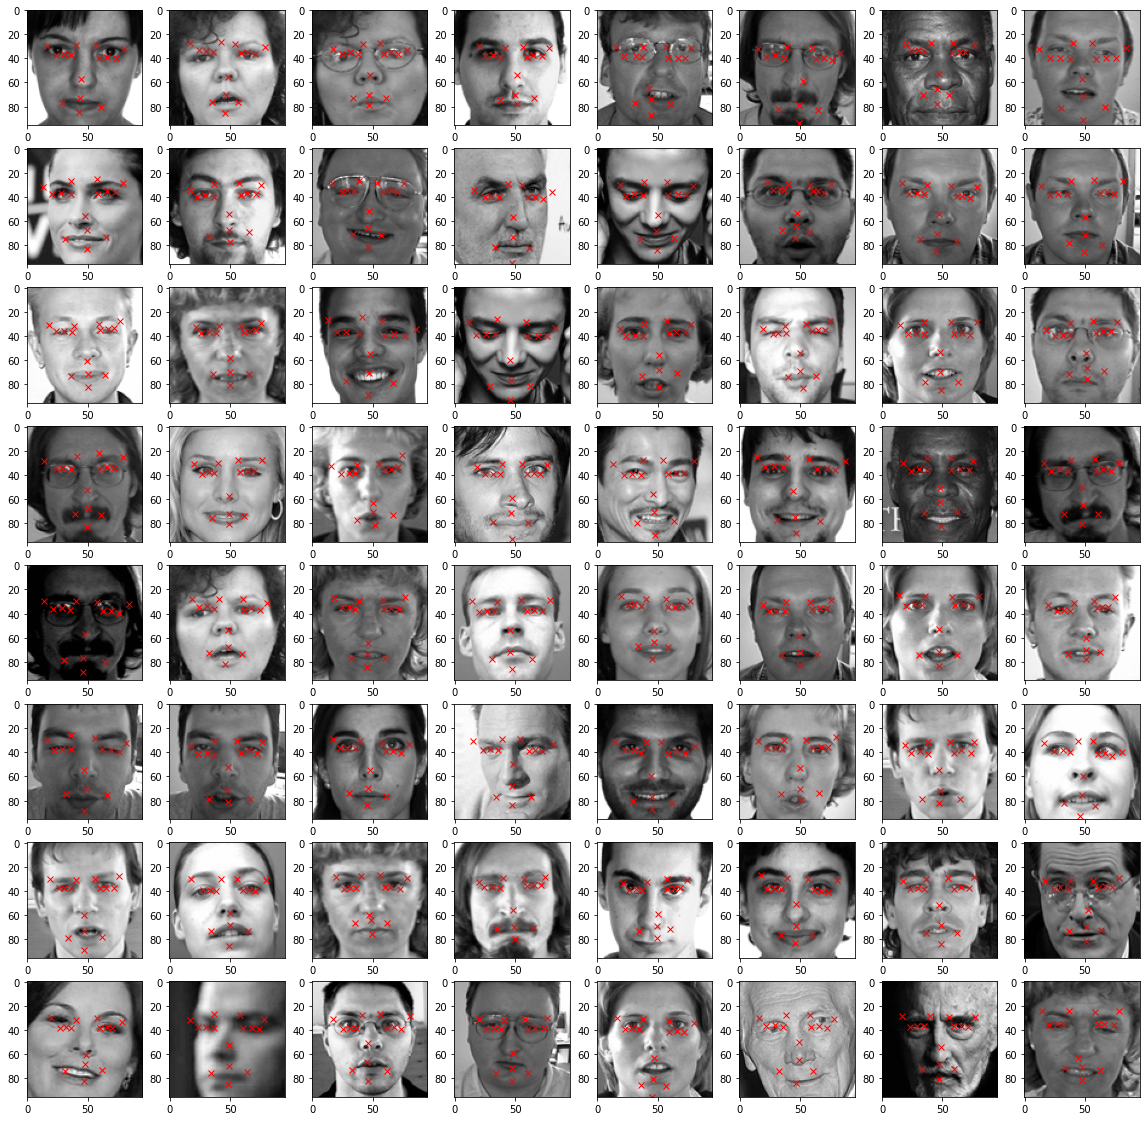

In [15]:
import random

fig = plt.figure(figsize= (20,20))

for i in range(64):
  k = np.random.randint(1,len(facialpoints_df))
  ax = fig.add_subplot(8,8,i+1)
  image = plt.imshow(facialpoints_df['Image'][k], cmap = 'gray')
  for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')

  



PERFORM IMAGE AUGMENTATION


In [16]:
# Create a new copy of the dataframe
import copy
facialpoints_df_copy = copy.copy(facialpoints_df)

In [17]:
# obtain the header of the DataFrame (names of columns) 

columns = facialpoints_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [18]:
# Take a look at the pixel values of a sample image and see if it makes sense!
facialpoints_df['Image'][0]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

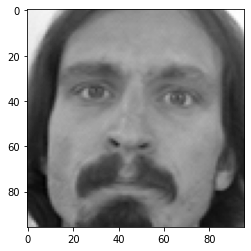

In [19]:
# plot the sample image
plt.imshow(facialpoints_df['Image'][0], cmap = 'gray')

In [20]:
# Now Let's flip the image column horizontally 
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

In [21]:
# Now take a look at the flipped image and do a sanity check!
# Notice that the values of pixels are now flipped
facialpoints_df_copy['Image'][0]

array([[250, 250, 250, ..., 237, 236, 238],
       [251, 250, 249, ..., 236, 238, 235],
       [250, 251, 251, ..., 237, 236, 237],
       ...,
       [ 60,  57,  52, ..., 181, 183, 186],
       [ 78,  69,  61, ..., 207, 188, 189],
       [ 90,  75,  70, ..., 184, 184, 191]])

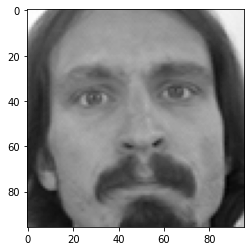

In [22]:
# Notice that the image is flipped now
plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')

In [23]:
# Since we are flipping the images horizontally, y coordinate values would be the same
# X coordinate values only would need to change, all we have to do is to subtract our initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 0:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

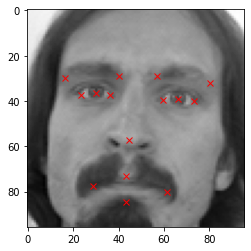

In [24]:
# View the Original image
plt.imshow(facialpoints_df['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df.loc[0][j-1], facialpoints_df.loc[0][j], 'rx')

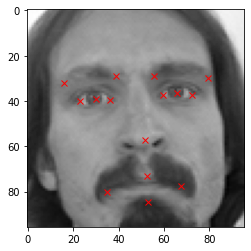

In [25]:
# View the Horizontally flipped image
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [26]:
# Concatenate the original dataframe with the augmented dataframe
facialpoints_df_augmented = np.concatenate((facialpoints_df,facialpoints_df_copy))

In [27]:
facialpoints_df_augmented.shape

(4280, 31)

In [28]:
# Let's try to perform another image augmentation by randomly increasing images brightness
# We multiply pixel values by random values between 1 and 2 to increase the brightness of the image
# we clip the value between 0 and 255

import random

facialpoints_df_copy = copy.copy(facialpoints_df)
facialpoints_df_copy['Image'] = facialpoints_df['Image'].apply(lambda x:np.clip(random.uniform(1, 2) * x, 0.0, 255.0))
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(6420, 31)

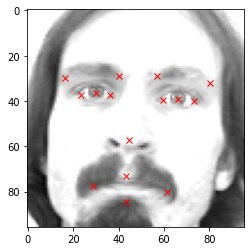

In [29]:
# Let's view image with increased brightness

plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

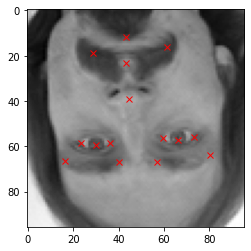

In [30]:

facialpoints_df_copy = copy.copy(facialpoints_df)
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

for i in range(1,30,2):
      facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [31]:
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented,facialpoints_df_copy))
facialpoints_df_augmented.shape

(8560, 31)

# TASK #5: PERFORM NORMALIZATION AND TRAINING DATA PREPARATION

In [32]:
# Obtain the value of 'Images' and normalize it
# Note that 'Images' are in the 31st column but since indexing start from 0, we refer 31st column by 30
img = facialpoints_df_augmented[:, 30]
img = img/255.

# Create an empty array of shape (10700, 96, 96, 1) to train the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the normalized images list and add image values to the empty array 
# Note that we need to expand it's dimension from (96,96) to (96,96,1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [33]:
# Obtain the values of key face points coordinates, which are to used as target.
y = facialpoints_df_augmented[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(8560, 30)

In [34]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

BUILD DEEP RESIDUAL NEURAL NETWORK MODEL

In [35]:
def res_block(X, filter, stage):
    
  # CONVOLUTIONAL BLOCK
  X_copy = X
  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1), strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # Add data from main and short paths
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

    
    
  # IDENTITY BLOCK 1
  X_copy = X
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # Add both paths together (Note that we feed the original input as is hence the name "identity")
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

    
    
  # IDENTITY BLOCK 2
  X_copy = X

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # Add both paths together (Note that we feed the original input as is hence the name "identity")
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [54]:
input_shape = (96,96,1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# Stage #1
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# Stage #2
X = res_block(X, filter= [64,64,256], stage= 2)

# Stage #3
X = res_block(X, filter= [128,128,512], stage= 3)

#Stage #4
X = res_block(X, filter= [256,256,1024], stage= 4)


# Max Pooling
X = MaxPooling2D((2,2), name = 'Max_pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model = Model( inputs= X_input, outputs = X)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 102, 102, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

# TASK #8: COMPILE AND TRAIN DEEP LEARNING MODEL

In [58]:
adam = tf.keras.optimizers.Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error", optimizer = adam, metrics = ['accuracy'])

In [59]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only = True)

In [60]:
history = model.fit(X_train, y_train, batch_size = 256, epochs= 100, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 55.7330 - accuracy: 0.7413
Epoch 00001: val_loss improved from inf to 56.78504, saving model to weights.hdf5
29/29 [==============================] - 5s 174ms/step - loss: 55.7330 - accuracy: 0.7413 - val_loss: 56.7850 - val_accuracy: 0.6632
Epoch 2/100
29/29 [==============================] - ETA: 0s - loss: 9.7462 - accuracy: 0.7763
Epoch 00002: val_loss did not improve from 56.78504
29/29 [==============================] - 3s 102ms/step - loss: 9.7462 - accuracy: 0.7763 - val_loss: 74.0509 - val_accuracy: 0.7927
Epoch 3/100
29/29 [==============================] - ETA: 0s - loss: 7.3788 - accuracy: 0.7972
Epoch 00003: val_loss improved from 56.78504 to 48.78788, saving model to weights.hdf5
29/29 [==============================] - 4s 142ms/step - loss: 7.3788 - accuracy: 0.7972 - val_loss: 48.7879 - val_accuracy: 0.7642
Epoch 4/100
29/29 [==============================] - ETA: 0s - loss: 10.3737 - accuracy: 0.7946


In [61]:
# Save trained model
model_json = model.to_json()
with open('KeyPointDetector.json', 'w') as json_file:
        json_file.write(model_json)

ASSESS TRAINED MODEL PERFORMANCE

In [62]:
# instead of training from scratch, you can load trained model weights
with open('KeyPointDetector.json', 'r') as json_file:
    json_SavedModel = json_file.read()
model = tf.keras.models.model_from_json(json_SavedModel)
model.load_weights('weights.hdf5')
model.compile(loss="mean_squared_error", optimizer = adam, metrics = ['accuracy'])

In [63]:
# Evaluate trained model
result = model.evaluate(X_test,y_test)
print("Accuracy : {}".format(result[1]))

27/27 [==============================] - 0s 9ms/step - loss: 26.9771 - accuracy: 0.8470
Accuracy : 0.8469626307487488


In [64]:
# Make prediction using the testing dataset
df_predict = model.predict(X_test)

In [65]:
# Print the rmse loss values

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, df_predict))
print("RMSE value : {}".format(rms))

RMSE value : 5.193943296432176


In [66]:
# Convert the predicted values into a dataframe

df_predict= pd.DataFrame(df_predict, columns = columns)
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,29.640078,37.937332,70.436256,35.918221,37.639153,38.840744,21.142185,39.501625,62.143829,37.444454,79.013329,36.674526,40.412510,26.789814,13.368073,30.576563,57.269024,25.453587,86.443108,27.057678,49.526802,59.660084,36.034637,83.129364,69.125793,81.299515,51.764473,78.018112,52.143642,88.128708
1,68.423317,37.973503,28.934340,36.449966,61.138668,38.657169,75.709259,39.281006,36.210812,37.591663,21.441267,37.138107,57.324894,30.252371,83.270554,32.110203,39.807911,29.245369,14.539703,29.431818,47.233292,56.149414,63.581921,79.516609,30.183006,78.391808,46.752388,73.478119,46.396610,88.316513
2,64.276573,35.227886,29.908115,34.083797,58.680233,35.985733,69.629265,36.077515,35.508297,35.139256,24.240599,34.531349,55.931759,29.781933,76.204178,29.925180,39.481533,28.999571,18.227268,28.137634,46.725159,55.073563,57.438515,72.914757,33.678959,71.963867,45.983498,68.110390,45.503529,79.243378
3,63.885197,34.777565,30.088434,39.202232,56.966610,36.890797,71.111320,34.763893,37.266827,39.562321,22.429796,41.179943,53.483318,29.376953,75.867531,27.829102,38.765079,31.599209,15.633780,36.061214,50.242943,57.586678,66.442970,72.835411,36.695930,76.507118,51.797585,73.661057,52.412109,78.240005
4,65.317650,35.892368,29.819525,36.964550,58.001556,37.121189,73.107193,36.801346,37.389355,37.661831,21.904818,38.343491,53.810127,27.766022,80.246719,29.971188,41.115635,28.303185,14.896773,32.020584,47.389751,54.736301,63.074303,73.064697,32.474255,73.688957,47.746964,69.556122,47.766777,78.518158


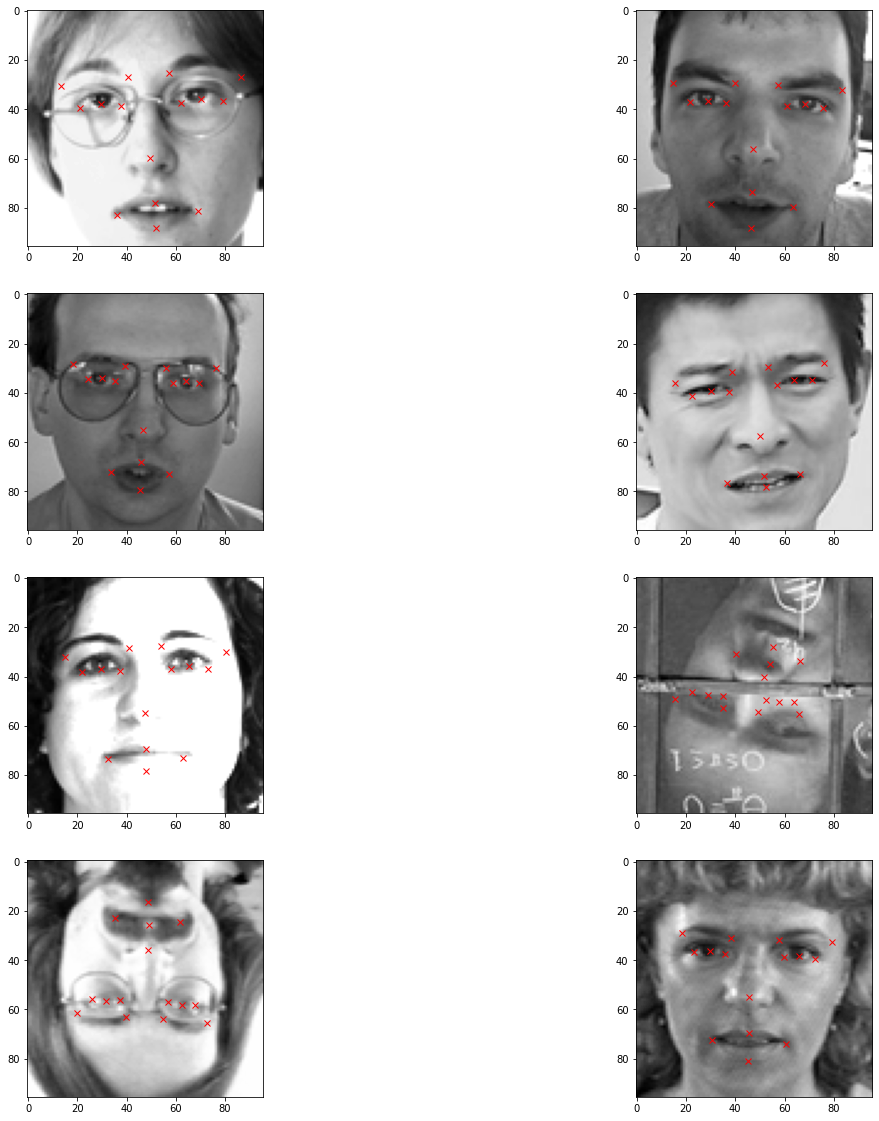

In [67]:
# Plot the test images and their predicted keypoints

fig = plt.figure(figsize=(20, 20))

for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1)
    # Using squeeze to convert the image shape from (96,96,1) to (96,96)
    plt.imshow(X_test[i].squeeze(),cmap='gray')
    for j in range(1,31,2):
            plt.plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')